In [1]:
pip install lightgbm catboost

In [2]:
!pip install -upgrade lightgbm catboost


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


# LightGBM

In [3]:
import pandas as pd

df = pd.read_csv('student-por.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,NaN,18.0,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,NaN,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15.0,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15.0,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16.0,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
y = df.iloc[:, -1]
X = df.iloc[:, :-3]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
import lightgbm as lgb

lgbr = lgb.LGBMRegressor(random_state=42)

In [7]:
cat_columns = X_train.columns[X_train.dtypes==object].tolist()
for c in cat_columns:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 213 to 102
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      486 non-null    category
 1   sex         485 non-null    category
 2   age         485 non-null    float64 
 3   address     486 non-null    category
 4   famsize     486 non-null    category
 5   Pstatus     486 non-null    category
 6   Medu        486 non-null    int64   
 7   Fedu        486 non-null    int64   
 8   Mjob        486 non-null    category
 9   Fjob        486 non-null    category
 10  reason      486 non-null    category
 11  guardian    485 non-null    category
 12  traveltime  486 non-null    int64   
 13  studytime   486 non-null    int64   
 14  failures    486 non-null    int64   
 15  schoolsup   486 non-null    category
 16  famsup      486 non-null    category
 17  paid        486 non-null    category
 18  activities  486 non-null    category
 19  nurser

In [9]:
from sklearn.model_selection import cross_validate

scores = cross_validate(lgbr, X_train, y_train, scoring='neg_root_mean_squared_error')
-scores['test_score'].mean()

2.8065197652823053

XGBoost 히스토램 기반 그레디언트 부스팅

In [10]:
X_oe = pd.get_dummies(X)
X_oe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                648 non-null    float64
 1   Medu               649 non-null    int64  
 2   Fedu               649 non-null    int64  
 3   traveltime         649 non-null    int64  
 4   studytime          649 non-null    int64  
 5   failures           649 non-null    int64  
 6   famrel             649 non-null    int64  
 7   freetime           649 non-null    int64  
 8   goout              649 non-null    int64  
 9   Dalc               649 non-null    int64  
 10  Walc               649 non-null    int64  
 11  health             649 non-null    int64  
 12  absences           649 non-null    int64  
 13  school_GP          649 non-null    uint8  
 14  school_MS          649 non-null    uint8  
 15  sex_F              649 non-null    uint8  
 16  sex_M              649 non

In [11]:
import xgboost as xgb

X_train_oe, X_test_oe = train_test_split(X_oe, random_state=42)

xgbr = xgb.XGBRegressor(tree_method='hist', grow_policy='lossguide')

scores = cross_validate(xgbr, X_train_oe, y_train, scoring='neg_root_mean_squared_error')
-scores['test_score'].mean()

[03:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2.7657000810524623

LightGBM 하이퍼파리미터 튜닝

In [12]:
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'num_leaves': randint(10, 100),
    'max_depth': randint(1, 10),
    'min_child_samples': randint(10, 40),
    'n_estimators': randint(50, 300),
    'learning_rate': loguniform(1e-3, 0.1),
    'subsample': loguniform(0.6, 1.0),
    'subsample_freq': randint(1, 5),
}

rs = RandomizedSearchCV(lgbr, param_grid, n_iter=300, 
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

print('최상의 매개변수:', rs.best_params_)
print('최상의 교차 검증 점수:', -rs.best_score_)

최상의 매개변수: {'learning_rate': 0.01740279894124973, 'max_depth': 2, 'min_child_samples': 20, 'n_estimators': 228, 'num_leaves': 47, 'subsample': 0.8224138832781182, 'subsample_freq': 2}
최상의 교차 검증 점수: 2.628202823091513


In [13]:
import joblib

lgbr = rs.best_estimator_

joblib.dump(lgbr, 'lightgbm_model.joblib')
lgbr = joblib.load('lightgbm_model.joblib')

In [14]:
from sklearn.metrics import mean_squared_error

y_pred = lgbr.predict(X_test)

mean_squared_error(y_pred, y_test, squared=False)

2.8381577707479617

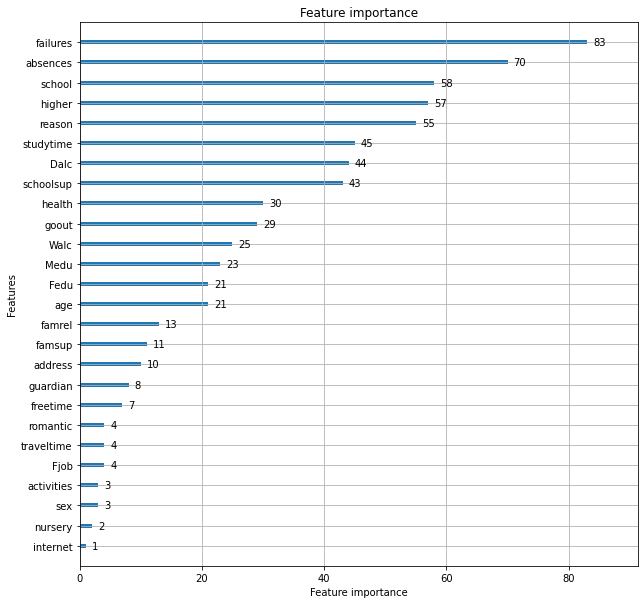

In [15]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgbr, figsize=(10,10))
plt.show()

[03:22:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


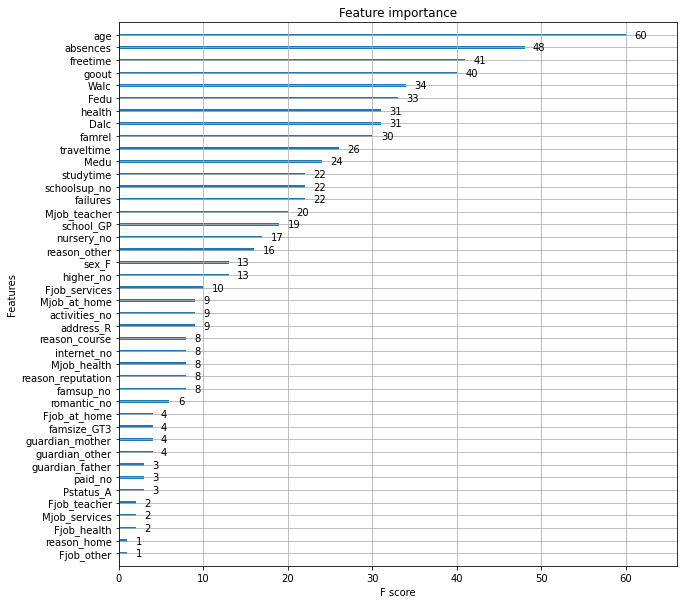

In [16]:
xgbr.fit(X_train_oe, y_train)

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xgbr, ax=ax)
plt.show()

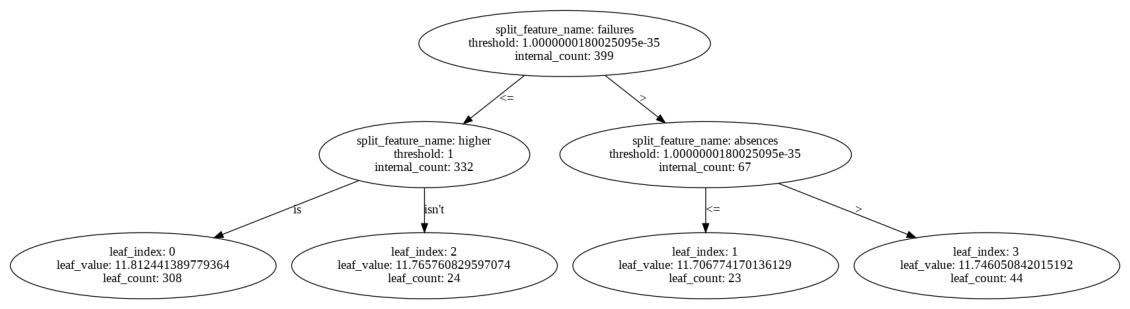

In [19]:
lgb.plot_tree(lgbr, tree_index=0, figsize=(20,10),
              show_info=['internal_count', 'leaf_count'])
plt.show()

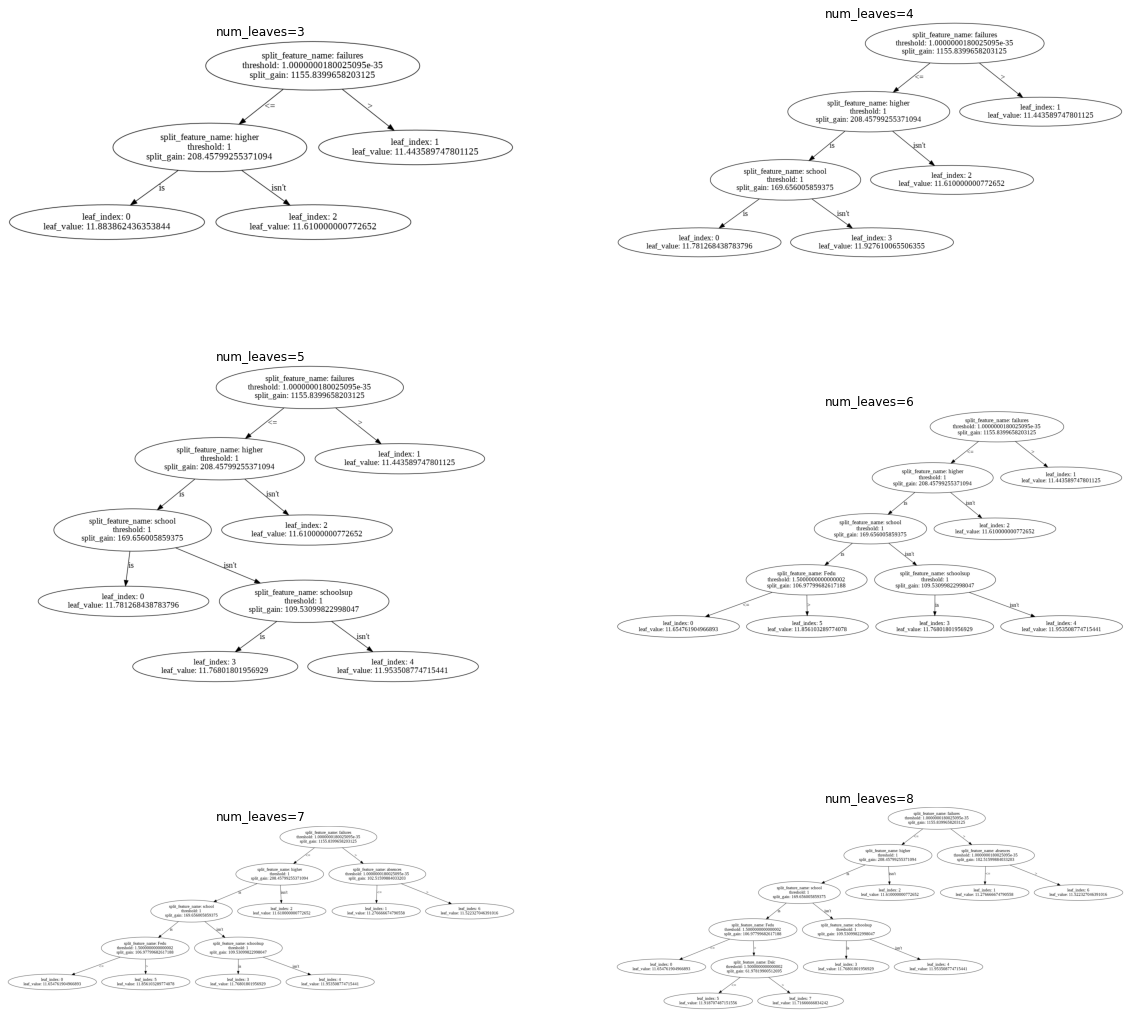

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i in range(0, 3):
  for j in range(0, 2):
    lgbr2 = lgb.LGBMRegressor(num_leaves=i*2+j+3)
    lgbr2.fit(X_train, y_train)
    lgb.plot_tree(lgbr2, tree_index=0, show_info=['split_gain'], ax=axs[i,j])
    axs[i, j].set_title('num_leaves={}'.format(i*2+j+3))

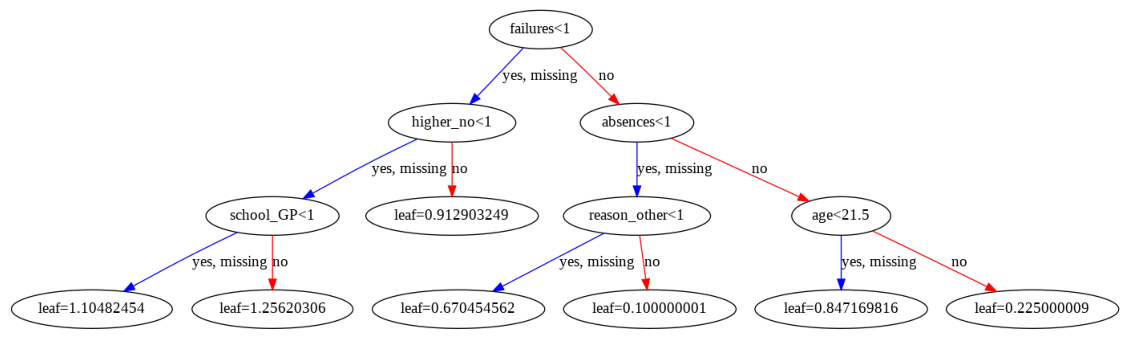

In [22]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(xgbr, num_trees=0, ax=ax)
plt.show()

# 히스토그램 기반 그레디언트 부스팅

In [24]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

cat_columns_bool = X_train.dtypes == 'category'
ct = ColumnTransformer([('ord', OrdinalEncoder(), cat_columns_bool)],
                         remainder='passthrough')
X_train_ord = ct.fit_transform(X_train)

In [26]:
import numpy as np
cat_num_names = np.append(ct.feature_names_in_[cat_columns_bool],
                          ct.feature_names_in_[~cat_columns_bool])

X_train_ord = pd.DataFrame(X_train_ord, columns=cat_num_names)[X_train.columns]
X_train_ord.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0.0,0.0,16.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,...,1.0,1.0,0.0,4.0,5.0,2.0,1.0,2.0,3.0,0.0
1,0.0,1.0,15.0,1.0,0.0,1.0,2.0,2.0,3.0,3.0,...,1.0,1.0,0.0,5.0,4.0,1.0,1.0,1.0,1.0,0.0
2,0.0,1.0,15.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,...,1.0,1.0,0.0,4.0,3.0,3.0,1.0,1.0,5.0,0.0
3,0.0,1.0,16.0,1.0,0.0,1.0,3.0,1.0,2.0,2.0,...,1.0,0.0,0.0,5.0,3.0,2.0,2.0,2.0,5.0,0.0
4,1.0,0.0,16.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,...,0.0,1.0,0.0,4.0,4.0,5.0,1.0,3.0,3.0,0.0


In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(categorical_features=cat_columns_bool,
                                     random_state=42)

scores = cross_validate(hgbr, X_train_ord, y_train,
                        scoring='neg_root_mean_squared_error')
-scores['test_score'].mean()

2.8096716836564264

In [28]:
from sklearn.inspection import permutation_importance

hgbr.fit(X_train_ord, y_train)
result = permutation_importance(hgbr, X_train_ord, y_train, random_state=42)

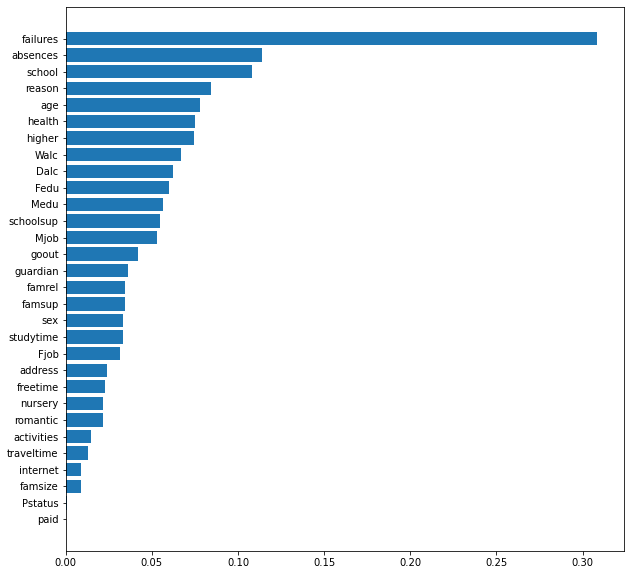

In [29]:
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.show()

# CatBoost

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

ct2 = ColumnTransformer([('str', mode_imputer, cat_columns_bool),
                         ('num', mean_imputer, ~cat_columns_bool)])

X_train_ct = pd.DataFrame(ct2.fit_transform(X_train),
                          columns=cat_num_names)
X_train_ct = X_train_ct[X_train.columns]
X_train_ct.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,16.0,U,LE3,T,4.0,4.0,teacher,teacher,...,yes,yes,no,4.0,5.0,2.0,1.0,2.0,3.0,0.0
1,GP,M,15.0,U,GT3,T,2.0,2.0,services,services,...,yes,yes,no,5.0,4.0,1.0,1.0,1.0,1.0,0.0
2,GP,M,15.0,U,GT3,T,4.0,4.0,services,teacher,...,yes,yes,no,4.0,3.0,3.0,1.0,1.0,5.0,0.0
3,GP,M,16.0,U,GT3,T,3.0,1.0,other,other,...,yes,no,no,5.0,3.0,2.0,2.0,2.0,5.0,0.0
4,MS,F,16.0,R,LE3,T,1.0,2.0,at_home,other,...,no,yes,no,4.0,4.0,5.0,1.0,3.0,3.0,0.0


In [31]:
param_grid = {
    'n_estimators': randint(100, 300),
    'depth': randint(4, 10),
    'learning_rate': loguniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy':['SymmetricTree', 'Lossguide', 'Depthwise']
}

In [32]:
cat_columns_idx = np.where(cat_columns_bool)[0]

In [35]:
import catboost as cb

cbr = cb.CatBoostRegressor(cat_features=cat_columns_idx,
                           verbose=False, random_seed=42)

In [36]:
rs = RandomizedSearchCV(cbr, param_grid, n_iter=100,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1, random_state=42)
rs.fit(X_train_ct, y_train)

print('최상의 매개변수:', rs.best_params_)
print('최상의 교차 검증 점수:', -rs.best_score_)

최상의 매개변수: {'depth': 6, 'grow_policy': 'Depthwise', 'learning_rate': 0.025924756604751586, 'min_child_samples': 12, 'n_estimators': 262}
최상의 교차 검증 점수: 2.605378509872569


In [37]:
cbr = cb.CatBoostRegressor(cat_features=cat_columns_idx, verbose=False, random_seed=42)
result = cbr.randomized_search(param_grid, X_train_ct, y_train, 
                               cv=5, n_iter=100, verbose=False)


bestTest = 2.383198925
bestIteration = 298


bestTest = 5.392005517
bestIteration = 252


bestTest = 2.320197654
bestIteration = 282


bestTest = 3.05268876
bestIteration = 101


bestTest = 3.407244028
bestIteration = 181


bestTest = 7.80346537
bestIteration = 246


bestTest = 2.484372373
bestIteration = 191


bestTest = 3.673478488
bestIteration = 221


bestTest = 9.051519123
bestIteration = 186


bestTest = 2.505605584
bestIteration = 160


bestTest = 4.917085676
bestIteration = 271


bestTest = 4.189215654
bestIteration = 154


bestTest = 7.313828108
bestIteration = 255


bestTest = 2.326242312
bestIteration = 266


bestTest = 2.33009441
bestIteration = 105


bestTest = 9.891600674
bestIteration = 114


bestTest = 2.720437661
bestIteration = 250


bestTest = 9.419831086
bestIteration = 235


bestTest = 6.9798971
bestIteration = 285


bestTest = 2.37647323
bestIteration = 199


bestTest = 9.258270281
bestIteration = 265


bestTest = 9.107458875
bestIteration = 186


bestTest = 2.56

In [38]:
print('최상의 매개변수:', result['params'])
print('최상의 교차 검증 점수:', result['cv_results']['test-RMSE-mean'][-1])

최상의 매개변수: {'min_data_in_leaf': 11.0, 'depth': 7.0, 'learning_rate': 0.043249655592161866, 'iterations': 267.0, 'grow_policy': 'SymmetricTree'}
최상의 교차 검증 점수: 2.6967173548593424


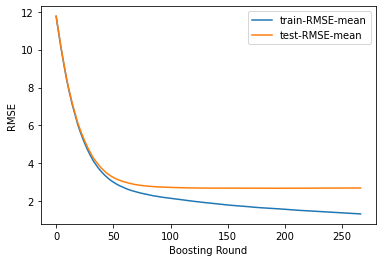

In [41]:
plt.plot(result['cv_results']['train-RMSE-mean'], label='train-RMSE-mean')
plt.plot(result['cv_results']['test-RMSE-mean'], label='test-RMSE-mean')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [42]:
cbr.save_model('catboost_model.cbm')
cbr = cb.CatBoostRegressor().load_model('catboost_model.cbm')

In [43]:
cbr.save_model('catboost_model.json', format='json')
cbr = cb.CatBoostRegressor().load_model('catboost_model.json', format='json')

In [44]:
X_test_ct = pd.DataFrame(ct2.transform(X_test),
                         columns=cat_num_names)
X_test_ct = X_test_ct[X_test.columns]

y_pred = cbr.predict(X_test_ct)
mean_squared_error(y_pred, y_test, squared=False)

2.837316047933014

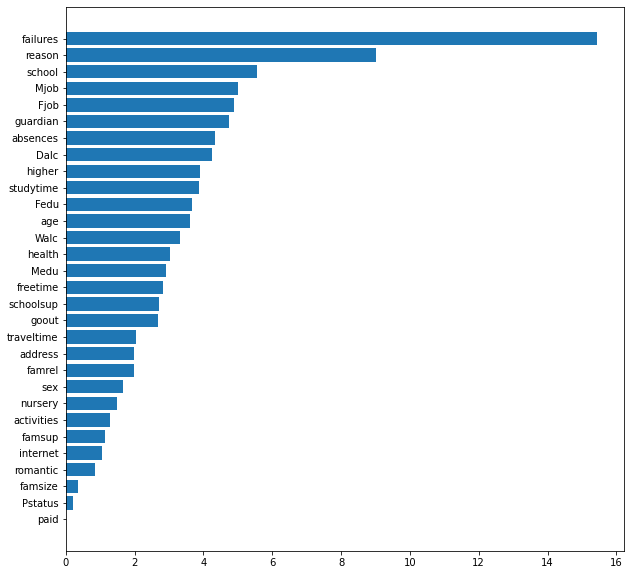

In [45]:
feature_importances = cbr.get_feature_importance()
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns[sorted_idx],feature_importances[sorted_idx])
plt.show()